In [4]:
import data
import tensorflow as tf
import typing
from typing import Any, Tuple

Data Loading and Processing

In [2]:
handlr = data.Train_Data('D:/DS/Learnin/Essex MS/CE888/git/CE888/assignment2/seq2seq/spider/',['train_spider.json','train_others.json'])
input_text_processor = data.Features().vectorizor(handlr.questions , data.Max_Vocab_Size)
output_text_processor = data.Features().vectorizor(handlr.sql , data.Max_Vocab_Size)

Reading file at path D:/DS/Learnin/Essex MS/CE888/git/CE888/assignment2/seq2seq/spider/train_spider.json
7000 Rows in Total
Reading file at path D:/DS/Learnin/Essex MS/CE888/git/CE888/assignment2/seq2seq/spider/train_others.json
8659 Rows in Total
Filter Easy Queries
Splittin the Train and Test data
(727, 7)
Data for Training (2908, 7)
Data for Testing (727, 7)
Sample Vocabulary ['', '[UNK]', 'the', '[start]', '[end]', 'of', '?', '.', 'what', 'are']
Sample Vocabulary ['', '[UNK]', 'select', 'from', '[start]', '[end]', 'where', ')', '(', '=']


Getting the List of Questions in inp and List of Queries as target

In [7]:
inp = handlr.questions
targ = handlr.sql

In [8]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = data.BATCH_SIZE

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [10]:
embedding_dim = data.embedding_dim
units = data.units

In [11]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                                embedding_dim)

        # The GRU RNN layer processes those vectors sequentially.
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                    # Return the sequence and state
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')

    def call(self, tokens, state=None):
        


        # 2. The embedding layer looks up the embedding for each token.
        vectors = self.embedding(tokens)


        # 3. The GRU processes the embedding sequence.
        #    output shape: (batch, s, enc_units)
        #    state shape: (batch, enc_units)
        output, state = self.gru(vectors, initial_state=state)


        # 4. Returns the new sequence and its state.
        return output, state

In [12]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        # For Eqn. (4), the  Bahdanau attention
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
       
        # From Eqn. (4), `W1@ht`.
        w1_query = self.W1(query)
       
        # From Eqn. (4), `W2@hs`.
        w2_key = self.W2(value)

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(
            inputs = [w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores = True,
        )

        return context_vector, attention_weights

In [13]:
attention_layer = BahdanauAttention(units)

In [14]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [15]:
class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any

class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

In [16]:
def call(self, inputs: DecoderInput, state=None) -> Tuple[DecoderOutput, tf.Tensor]:

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
 

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)

  return DecoderOutput(logits, attention_weights), state

In [17]:
Decoder.call = call

In [18]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [19]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

    def __call__(self, y_true, y_pred):
        # Calculate the loss for each item in the batch.
        loss = self.loss(y_true, y_pred)

        # Mask off the losses on padding.
        mask = tf.cast(y_true != 0, tf.float32)
        loss *= mask

        # Return the total.
        return tf.reduce_sum(loss)

In [20]:
class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(input_text_processor.vocabulary_size(),
                        embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(),
                        embedding_dim, units)

        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function

    def train_step(self, inputs):
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
         return self._train_step(inputs)

In [21]:
def _preprocess(self, input_text, target_text):
  

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  

  # Convert IDs to masks.
  input_mask = input_tokens != 0
 

  target_mask = target_tokens != 0
  

  return input_tokens, input_mask, target_tokens, target_mask

In [22]:
TrainTranslator._preprocess = _preprocess

In [23]:
def _train_step(self, inputs):
    input_text, target_text = inputs  

    (input_tokens, input_mask,target_tokens, target_mask) = self._preprocess(input_text, target_text)

    max_target_length = tf.shape(target_tokens)[1]

    with tf.GradientTape() as tape:
        # Encode the input
        enc_output, enc_state = self.encoder(input_tokens)
        

        # Initialize the decoder's state to the encoder's final state.
        # This only works if the encoder and decoder have the same number of
        # units.
        dec_state = enc_state
        loss = tf.constant(0.0)

        for t in tf.range(max_target_length-1):
            # Pass in two tokens from the target sequence:
            # 1. The current input to the decoder.
            # 2. The target for the decoder's next prediction.
            new_tokens = target_tokens[:, t:t+2]
            step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                                    enc_output, dec_state)
            loss = loss + step_loss

    # Average the loss over all non padding tokens.
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

In [24]:
TrainTranslator._train_step = _train_step

In [133]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                                enc_output=enc_output,
                                mask=input_mask)

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)


    # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    # print(y_pred.as_numpy_iterator())
    step_loss = self.loss(y, y_pred)

    return step_loss, dec_state

In [134]:
TrainTranslator._loop_step = _loop_step

In [135]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [136]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [137]:
TrainTranslator._tf_train_step = _tf_train_step


In [138]:
translator.use_tf_function = True


In [139]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [140]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [141]:
import os
import time
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

In [142]:
history = train_translator.fit(dataset, epochs=50, callbacks=[batch_loss,tensorboard_cb])

Epoch 1/50
46/46 [==============================] - 126s 3s/step - batch_loss: 4.8429
Epoch 2/50
46/46 [==============================] - 117s 3s/step - batch_loss: 3.0781
Epoch 3/50
46/46 [==============================] - 118s 3s/step - batch_loss: 2.3434
Epoch 4/50
46/46 [==============================] - 118s 3s/step - batch_loss: 2.0450
Epoch 5/50
46/46 [==============================] - 122s 3s/step - batch_loss: 1.8140
Epoch 6/50
46/46 [==============================] - 120s 3s/step - batch_loss: 1.5988
Epoch 7/50
46/46 [==============================] - 127s 3s/step - batch_loss: 1.4064
Epoch 8/50
46/46 [==============================] - 120s 3s/step - batch_loss: 1.2233
Epoch 9/50
46/46 [==============================] - 3720s 83s/step - batch_loss: 1.0401
Epoch 10/50
46/46 [==============================] - 120s 3s/step - batch_loss: 0.8761
Epoch 11/50
46/46 [==============================] - 121s 3s/step - batch_loss: 0.7218
Epoch 12/50
46/46 [==============================]

Text(0, 0.5, 'Batch Loss')

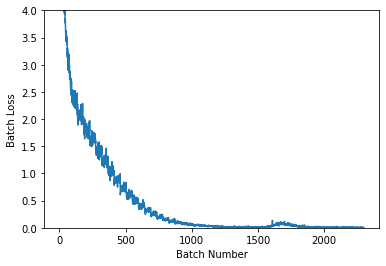

In [223]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 6), dpi=200)
plt.plot(batch_loss.logs)
plt.ylim([0, 4])
plt.xlabel('Batch Number')
plt.ylabel('Batch Loss')


In [209]:
batch_loss.logs

[7.051624774932861,
 7.048401832580566,
 6.908292770385742,
 6.5229058265686035,
 5.454949855804443,
 8.64066219329834,
 7.918764114379883,
 6.329209327697754,
 6.27166223526001,
 5.726656436920166,
 5.531042098999023,
 5.152456283569336,
 4.808164596557617,
 4.759221076965332,
 4.648735523223877,
 4.560144424438477,
 4.630853176116943,
 4.651496887207031,
 4.443292617797852,
 4.563898086547852,
 4.47241735458374,
 4.380863666534424,
 4.285150527954102,
 4.366373062133789,
 4.561182975769043,
 4.338625431060791,
 4.387815952301025,
 4.203274250030518,
 4.27259635925293,
 4.176522731781006,
 4.298745155334473,
 4.23585844039917,
 4.14679479598999,
 4.146397113800049,
 4.241480350494385,
 4.063497543334961,
 4.253663063049316,
 3.9712228775024414,
 3.9840433597564697,
 3.925319194793701,
 4.13038444519043,
 4.067673206329346,
 3.9402806758880615,
 3.7709476947784424,
 3.8467326164245605,
 3.763396739959717,
 3.69238018989563,
 3.643933057785034,
 3.531745433807373,
 3.4368627071380615,
 

In [145]:
class Translator(tf.Module):
    
  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[unk]', '[start]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[start]'))
    self.end_token = index_from_string(tf.constant('[end]'))

In [148]:
import numpy as np
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [149]:
def tokens_to_text(self, result_tokens):
    
    result_text_tokens = self.output_token_string_from_index(result_tokens)
   

    result_text = tf.strings.reduce_join(result_text_tokens,
                                        axis=1, separator=' ')
    

    result_text = tf.strings.strip(result_text)
    
    return result_text

In [150]:
Translator.tokens_to_text = tokens_to_text

In [160]:
# example_output_tokens = tf.random.uniform(
#     shape=[5, 2], minval=0, dtype=tf.int64,
#     maxval=output_text_processor.vocabulary_size())
# translator.tokens_to_text(example_output_tokens).numpy()

In [161]:
def sample(self, logits, temperature):

    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]

    # Set the logits for all masked tokens to -inf, so they are never chosen.
    logits = tf.where(self.token_mask, -np.inf, logits)

    if temperature == 0.0:
        new_tokens = tf.argmax(logits, axis=-1)
    else: 
        logits = tf.squeeze(logits, axis=1)
        new_tokens = tf.random.categorical(logits/temperature,
                                            num_samples=1)

    return new_tokens

Translator.sample = sample


In [162]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[ 661],
       [ 323],
       [ 738],
       [ 911],
       [1866]], dtype=int64)>

In [163]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [164]:
Translator.translate = translate_unrolled

In [165]:
%%time
input_text = tf.constant([
    'How many singers do we have?', # "It's really cold here."
    'What is the total number of singers?', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

select count ( * ) from event
sum select count ( * ) from department )

Wall time: 245 ms


In [175]:
test = list(handlr.df_test['question'].values)

input_text = tf.constant(test)

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

select count ( * ) from team_franchise where active = 'y';
select count ( * ) from products where product_category_code = "spices" and typical_buying_price > 1000



In [180]:
query = handlr.df_test['query'].values

In [208]:
count = 0
for i in range(len(test)):
    # print(test[i])
    # print("Predicted")
    pred = result['text'][i].numpy().decode().lower().replace(' ','')
    # print(pred)
    # print("Actual")
    act = query[i].lower().replace(' ','')
    # print(act)
    if pred == act:
        count = count +1
print("Accuracy is {:.2f} %".format(count*100/len(test)))

Accuracy is 33.56 %


In [ ]:
# run_2022_04_25-13_08_09